## 1. Loading necessary libraries

In [126]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [127]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

# import modelling_pipeline as modelling_pipeline
# reload(modelling_pipeline)

# modelling_pipeline = modelling_pipeline.modelling_pipeline(ROOT_DIR)

In [128]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [129]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


## 3. Input Dataset Extraction

In [130]:
# t0
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)

In [131]:
# t2
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)

In [132]:
# t4
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 4. Data processing

### 4.1 Train/ test split

In [133]:
path_t0_df = ROOT_DIR / 'data' / 'Model input data' / "t0.csv"  
t0_df = pd.read_csv(path_t0_df)
t0_df

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
0,3,145834,76,0,0,-999.0,-999.0,-999.0,25.0,8.2,...,30.2,10.0,1.3,8.0,81.0,282.0,13.5,15.1,3.44,12.7
1,4,185777,47,1,0,-999.0,-999.0,-999.0,24.0,8.9,...,34.2,11.5,-999.0,6.9,89.6,207.0,-999.0,13.6,3.80,9.7
2,9,150750,41,0,0,-999.0,-999.0,-999.0,30.0,-999.0,...,45.2,15.4,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5
3,11,194540,50,1,0,-999.0,-999.0,-999.0,25.0,-999.0,...,36.9,12.5,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5
4,12,112213,72,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,38.3,12.8,-999.0,-999.0,-999.0,339.0,-999.0,14.2,4.15,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34420,99966,167228,77,0,0,-999.0,-999.0,-999.0,21.0,9.0,...,35.6,12.6,1.1,17.0,77.4,185.0,12.5,15.3,4.17,11.0
34421,99973,150202,65,1,0,-999.0,-999.0,-999.0,13.0,-999.0,...,28.0,9.6,1.3,16.7,78.5,323.0,14.6,15.5,3.25,17.2
34422,99982,112748,65,0,0,-999.0,-999.0,-999.0,34.0,-999.0,...,33.6,11.2,2.4,15.0,77.9,145.0,24.8,16.5,3.48,6.1
34423,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,...,36.4,12.4,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0


In [134]:
path_t2_df = ROOT_DIR / 'data' / 'Model input data' / "t2.csv"  
t2_df = pd.read_csv(path_t2_df)
path_t4_df = ROOT_DIR / 'data' / 'Model input data' / "t4.csv"  
t4_df = pd.read_csv(path_t4_df)

In [135]:
def split_data(df_train):
    """
    Split data into training and test sets.
    Standardise numerical features.
    
    Compare performances of different models.
    Perform hyperparameter tuning on best model.
    Validate the optimal model's performance on the test set.
    Generate predictions for unknown data using the optimal model.
    
    Parameters:
    - df_train: Processed data for model training
    - test_size: 
    
    Returns:
    - X train, X test, y train, y test 
    """
         
    # Target and Predictors
    X = df_train.drop('IS_SEPSIS', axis='columns')
    y = df_train['IS_SEPSIS']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Fit the scaler and transform the X train and test sets
    # Standardising (not normalising!)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### 4.2 Feature Scaling

In [136]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = split_data(t0_df)

In [137]:
X_t2_train, X_t2_test, y_t2_train, y_t2_test = split_data(t2_df)
X_t4_train, X_t4_test, y_t4_train, y_t4_test = split_data(t4_df)

## 5. Model Fitting

### 5.1 Logistic regression

In [192]:
# Calculate class weights
label_counts = y_t0_train.value_counts()
class_weights = {0: 1/(label_counts[0]/len(y_t0_train)), 1: 1/(label_counts[1]/len(y_t0_train))}

# Round the class weights to the desired precision (optional)
class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 1.1273, 1: 8.8553}


In [193]:
label_counts[0]/len(y_t0_train)

0.8870733478576616

In [194]:
label_counts[1]/len(y_t0_train)

0.11292665214233842

##### 5.1.1 t0

In [195]:
# Fitting a Logistic Regression Classifier
t0_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t0_lr.fit(X_t0_train, y_t0_train)

t0_lr_predictions = t0_lr.predict(X_t0_test)
t0_lr_predicted_probabilities = t0_lr.predict_proba(X_t0_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### 5.1.1 Performance Measure

In [196]:
# Function for performance measures on (i) confusion matrix, (ii) balanced accuracy, (iii) precision, (iv) recall and (v) F1 score
def performance_measure(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Computating the confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    # Computing balanced accuracy
    balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    print("\nBalanced Accuracy: Training set {:.4f}".format(balanced_acc_train), "; Test set {:.4f}".format(balanced_acc_test))    

    # Computing precision and recall
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    print("Precision: Training set {:.4f}".format(precision_train), "; Test set {:.4f}".format(precision_test))
    print("Recall: Training set {:.4f}".format(recall_train), "; Test set {:.4f}".format(recall_test))

    # Computing F1 score
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    print("F1 score: Training set {:.4f}".format(f1_train), "; Test set {:.4f}".format(f1_test))

In [141]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

Performance measures on Logistic Regression Classifier:



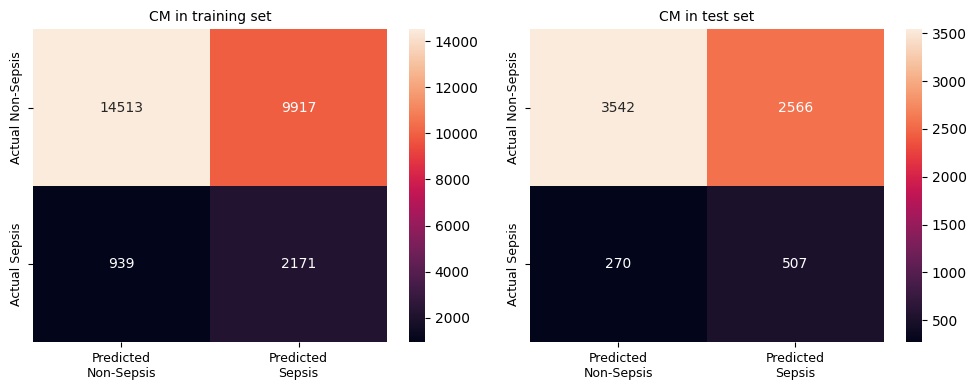


Balanced Accuracy: Training set 0.6461 ; Test set 0.6162
Precision: Training set 0.1796 ; Test set 0.1650
Recall: Training set 0.6981 ; Test set 0.6525
F1 score: Training set 0.2857 ; Test set 0.2634


In [197]:
print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t0_lr, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

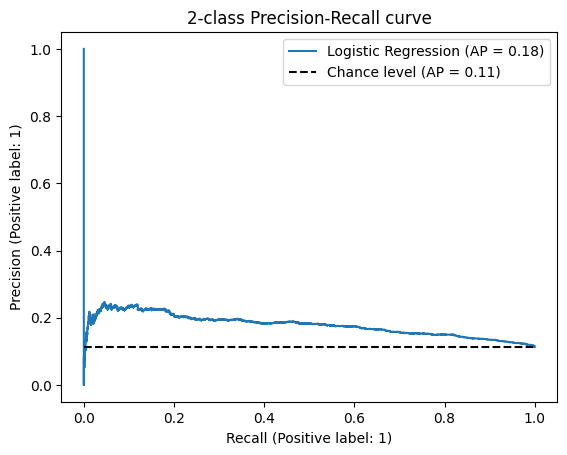

In [198]:
display = PrecisionRecallDisplay.from_estimator(
    t0_lr, X_t0_test, y_t0_test, name="Logistic Regression", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.6570


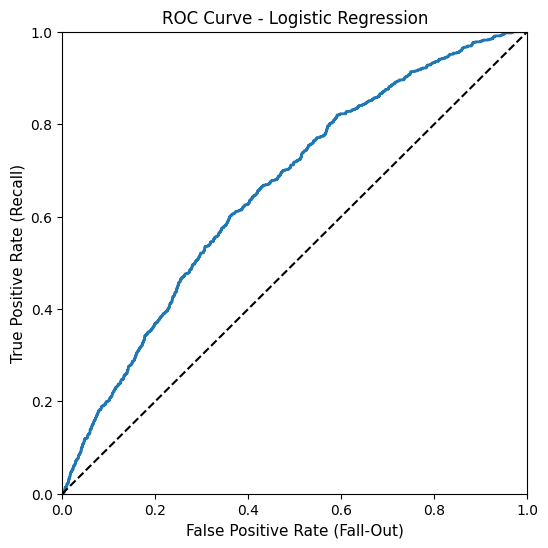

In [199]:
# Plotting ROC curve
fpr_lr_test, tpr_lr_test, thresholds_roc_lr_test = roc_curve(y_t0_test, t0_lr_predicted_probabilities[:, 1], pos_label=1)
auc_t0_lr = auc(fpr_lr_test, tpr_lr_test)
print("AUC = {:.4f}".format(auc_t0_lr))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_lr_test, tpr_lr_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(False)
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
The figure layout has changed to tight
The figure layout has changed to tight


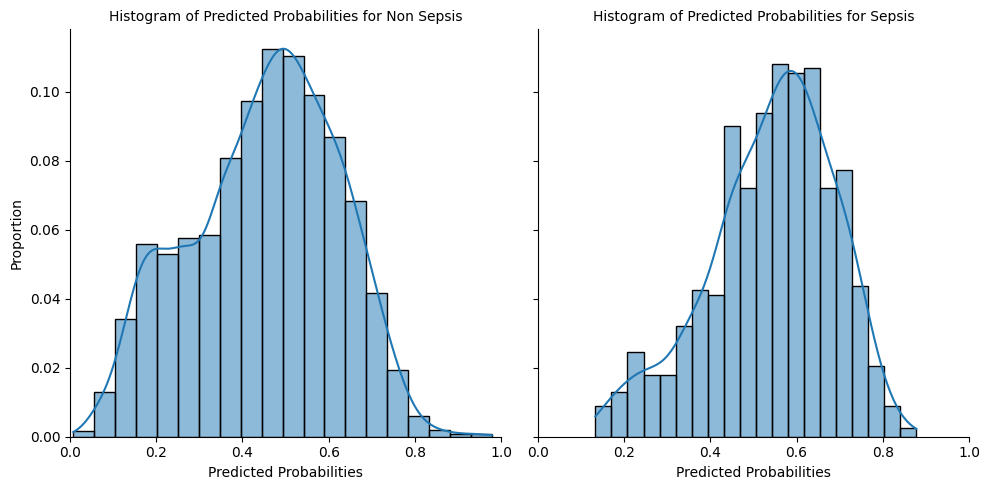

In [200]:
# Create two separate Series for each class based on predicted probabilities
predicted_probabilities_sepsis = t0_lr_predicted_probabilities[:, 1][y_t0_test == 1]
predicted_probabilities_no_sepsis = t0_lr_predicted_probabilities[:, 1][y_t0_test == 0]

# Combine the data for both classes into a single DataFrame with a 'Class' column
df_sepsis_lr = pd.DataFrame({'Predicted Probabilities': predicted_probabilities_sepsis, 'Class': 'Sepsis'})
df_no_sepsis_lr = pd.DataFrame({'Predicted Probabilities': predicted_probabilities_no_sepsis, 'Class': 'Non Sepsis'})
combined_df_lr = pd.concat([df_no_sepsis_lr, df_sepsis_lr])

# Create facet subplots, one on top of the other
g = sns.FacetGrid(combined_df_lr, col="Class", height=5)
g.map(sns.histplot, "Predicted Probabilities", bins=20, kde=True, stat="probability")

# Set x-axis limits to [0, 1] for both subplots
g.set(xlim=(0, 1))

# Set y-axis as proportions
g.set_ylabels("Proportion")

# Set axis labels and titles
g.set_axis_labels("Predicted Probabilities", "Proportion")
g.set_titles("Histogram of Predicted Probabilities for {col_name}")

# Show the facet subplots
plt.tight_layout()
plt.show()

#### 5.1.2 t2

In [201]:
# Fitting a Logistic Regression Classifier
t2_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t2_lr.fit(X_t2_train, y_t2_train)

t2_lr_predictions = t2_lr.predict(X_t2_test)
t2_lr_predicted_probabilities = t2_lr.predict_proba(X_t2_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Performance measures on Logistic Regression Classifier:



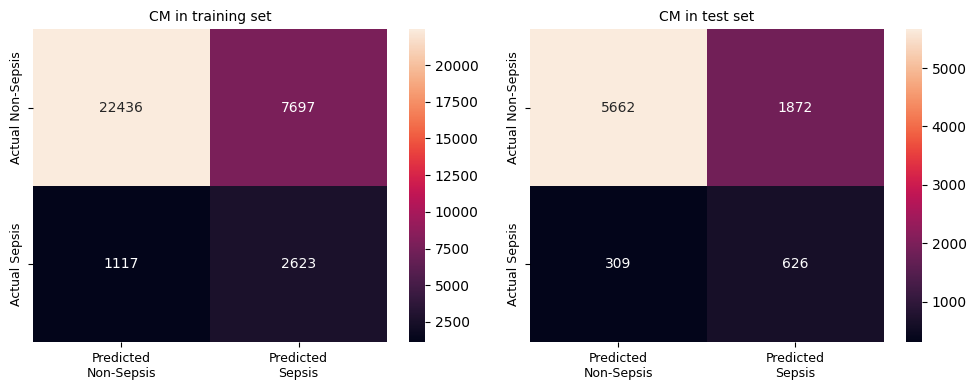


Balanced Accuracy: Training set 0.7230 ; Test set 0.7105
Precision: Training set 0.2542 ; Test set 0.2506
Recall: Training set 0.7013 ; Test set 0.6695
F1 score: Training set 0.3731 ; Test set 0.3647


In [202]:
print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t2_lr, X_t2_train, X_t2_test, y_t2_train, y_t2_test)

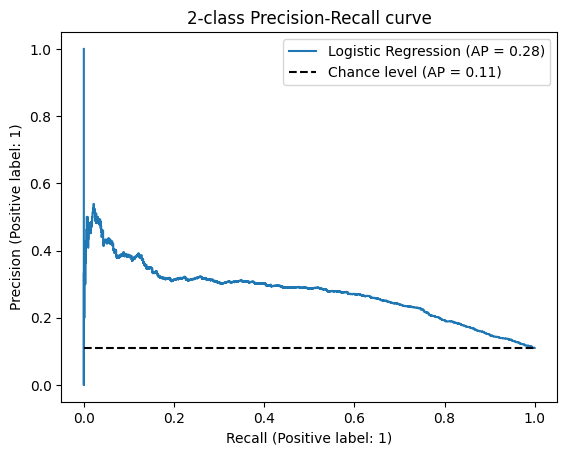

In [203]:
display = PrecisionRecallDisplay.from_estimator(
    t2_lr, X_t2_test, y_t2_test, name="Logistic Regression", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.7604


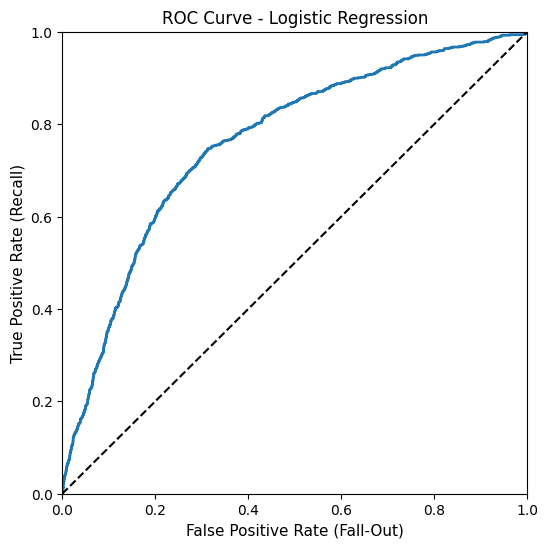

In [204]:
# Plotting ROC curve
fpr_t2_lr_test, tpr_t2_lr_test, thresholds_t2_roc_lr_test = roc_curve(y_t2_test, t2_lr_predicted_probabilities[:, 1], pos_label=1)
auc_t2_lr = auc(fpr_t2_lr_test, tpr_t2_lr_test)
print("AUC = {:.4f}".format(auc_t2_lr))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t2_lr_test, tpr_t2_lr_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(False)
plt.show()

#### 5.1.3 t4

In [205]:
# Fitting a Logistic Regression Classifier
t4_lr = LogisticRegression(random_state=901, class_weight=class_weights)
t4_lr.fit(X_t4_train, y_t4_train)

t4_lr_predictions = t4_lr.predict(X_t4_test)
t4_lr_predicted_probabilities = t4_lr.predict_proba(X_t4_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Performance measures on Logistic Regression Classifier:



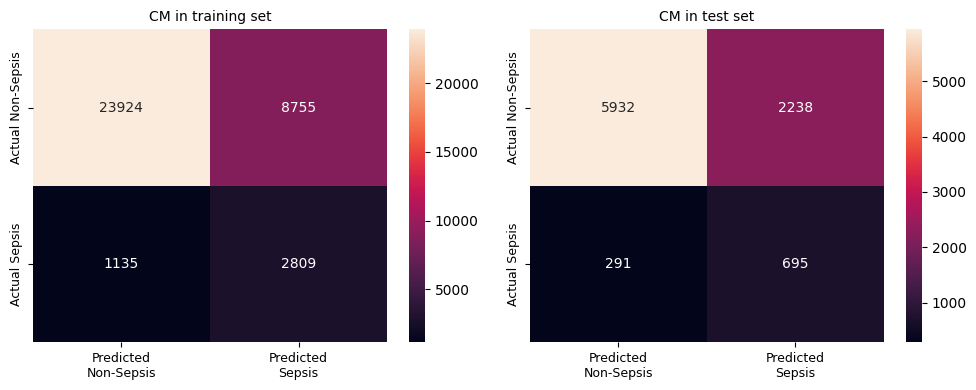


Balanced Accuracy: Training set 0.7222 ; Test set 0.7155
Precision: Training set 0.2429 ; Test set 0.2370
Recall: Training set 0.7122 ; Test set 0.7049
F1 score: Training set 0.3623 ; Test set 0.3547


In [206]:
print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t4_lr, X_t4_train, X_t4_test, y_t4_train, y_t4_test)

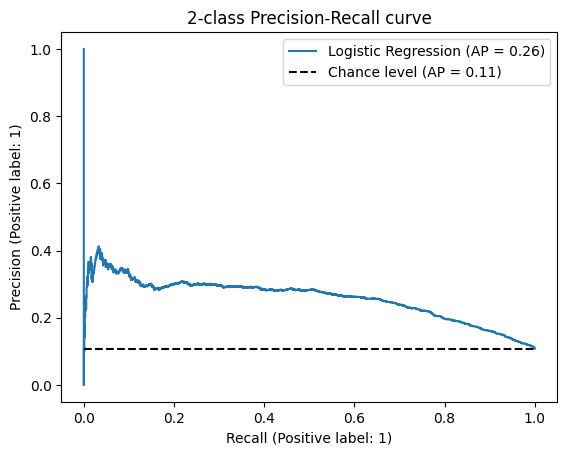

In [207]:
display = PrecisionRecallDisplay.from_estimator(
    t4_lr, X_t4_test, y_t4_test, name="Logistic Regression", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.7695


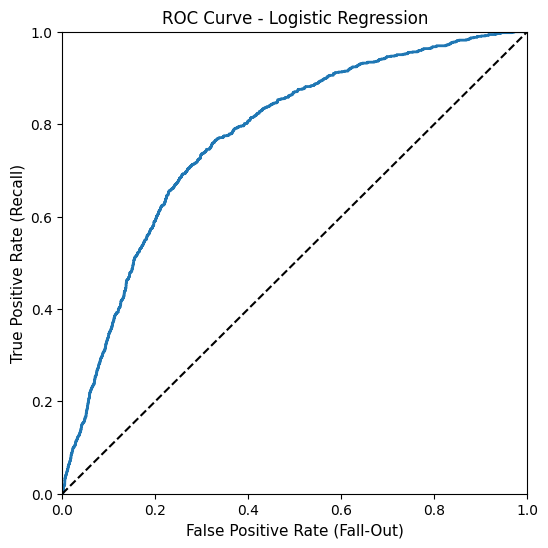

In [208]:
# Plotting ROC curve
fpr_t4_lr_test, tpr_t4_lr_test, thresholds_t4_roc_lr_test = roc_curve(y_t4_test, t4_lr_predicted_probabilities[:, 1], pos_label=1)
auc_t4_lr = auc(fpr_t4_lr_test, tpr_t4_lr_test)
print("AUC = {:.4f}".format(auc_t4_lr))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t4_lr_test, tpr_t4_lr_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(False)
plt.show()

#### 5.1.3 Feature Selection

In [209]:
feature_coeff_lr = t0_lr.coef_[0]
feature_names_lr = train_t0_df.columns[:-1]
feature_importance_lr = list(zip(feature_names_lr, feature_coeff_lr))
sorted_features_lr = sorted(feature_importance_lr, key=lambda x: abs(x[1]), reverse=True)

print('Feature importance from Logistic Regression:\n')

# Determine the maximum length of feature names for alignment
max_length = max([len(feature) for feature, _ in sorted_features_lr])

for feature, coef in sorted_features_lr:
    # Use ljust() to align feature names
    print('{} Coefficient: {:.4f}'.format(feature.ljust(max_length), coef))


Feature importance from Logistic Regression:

ITEMID_51256 Coefficient: 4.9408
ITEMID_51244 Coefficient: -4.4377
ITEMID_51237 Coefficient: -1.2720
ITEMID_51301 Coefficient: 1.2676
ITEMID_51274 Coefficient: 1.1159
ITEMID_51221 Coefficient: -0.7749
ITEMID_50912 Coefficient: -0.5499
ITEMID_51006 Coefficient: 0.5173
ITEMID_50821 Coefficient: -0.4801
ITEMID_51265 Coefficient: -0.4635
ITEMID_51279 Coefficient: -0.4465
ITEMID_51277 Coefficient: 0.3723
ITEMID_50813 Coefficient: 0.2796
ITEMID_51222 Coefficient: -0.2144
AGE          Coefficient: 0.1786
ITEMID_50931 Coefficient: -0.1711
ITEMID_50882 Coefficient: 0.1598
ITEMID_50893 Coefficient: 0.1503
ITEMID_50970 Coefficient: 0.1326
SUBJECT_ID   Coefficient: 0.1071
ITEMID_50902 Coefficient: -0.0288
GENDER_NUM   Coefficient: -0.0238
HADM_ID      Coefficient: -0.0222
ITEMID_50820 Coefficient: 0.0134


In [210]:
top_10_features_lr = sorted_features_lr[:10]
top_10_df_lr = pd.DataFrame(top_10_features_lr, columns=["LR_Feature", "Coefficient"])
top_10_df_lr

,LR_Feature,Coefficient
0,ITEMID_51256,4.940815
1,ITEMID_51244,-4.437744
2,ITEMID_51237,-1.272032
3,ITEMID_51301,1.267591
4,ITEMID_51274,1.115903
5,ITEMID_51221,-0.774896
6,ITEMID_50912,-0.549914
7,ITEMID_51006,0.517322
8,ITEMID_50821,-0.480124
9,ITEMID_51265,-0.463467


#### 5.1.3 SHAP

In [211]:
feature_columns = t0_df.columns.drop("IS_SEPSIS").tolist()
target_column = ["IS_SEPSIS"]

# Convert numpy array back to DataFrame
X_t0_train_df = pd.DataFrame(X_t0_train, columns=feature_columns)
y_t0_train_df = pd.DataFrame(y_t0_train, columns=target_column)

X_t0_test_df = pd.DataFrame(X_t0_test, columns=feature_columns)
y_t0_test_df = pd.DataFrame(y_t0_test, columns=target_column)

In [212]:
explainer_lr = shap.Explainer(t0_lr, X_t0_train_df)  # Create an explainer for your model
shap_values_lr = explainer_lr(X_t0_test_df)  # Calculate SHAP values for your test data

# set a display version of the data to use for plotting (has string values)
shap_values_lr.display_data = shap.datasets.adult(display=True)[0].values

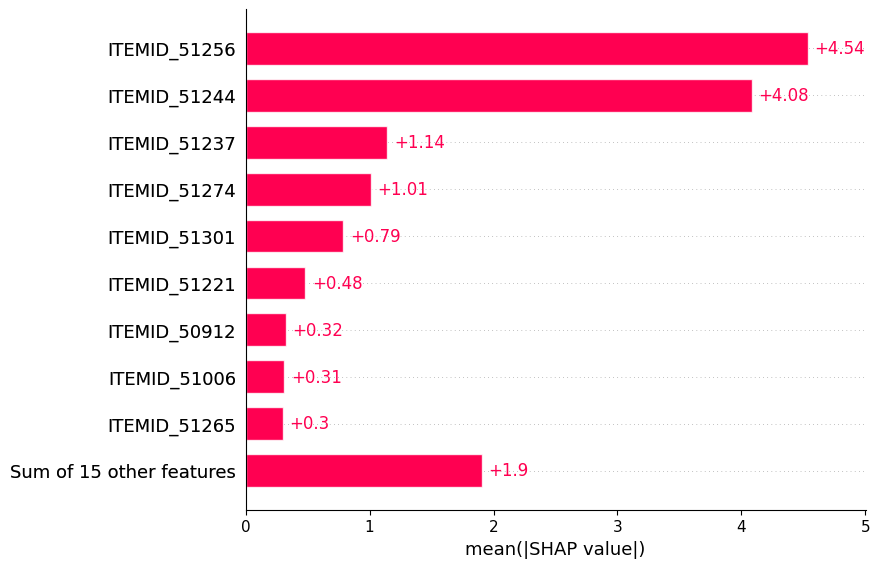

In [213]:
shap.plots.bar(shap_values_lr)

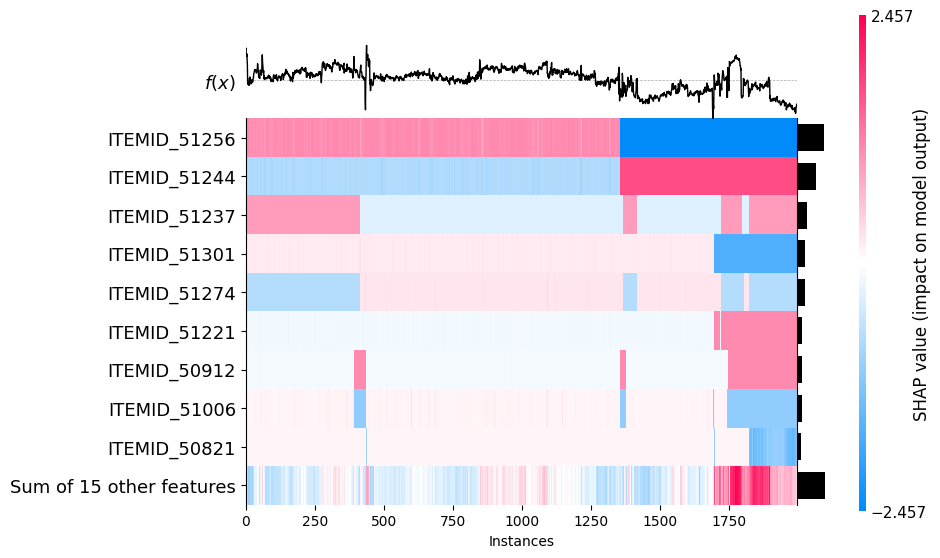

In [159]:
shap.plots.heatmap(shap_values_lr[:2000])

### 5.2 Random Forest

#### 5.2.1 t0

In [214]:
t0_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t0_rf_best.fit(X_t0_train, y_t0_train)

# Predict the test set using the best random forest regressor
y_pred_rf = t0_rf_best.predict(X_t0_test)
y_pred_rf = np.round(y_pred_rf) # Round the predictions to the nearest integer
t0_rf_predicted_probabilities = t0_rf_best.predict_proba(X_t0_test)

In [215]:
# Define the RMSE scoring metric as a callable
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Compute the RMSE of the predictions on the test set
rmse_rf = np.sqrt(mean_squared_error(y_t0_test, y_pred_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_rf))

Random Forest Classifier Test set RMSE: 0.5315


Performance measures on Random Forest Classifier:



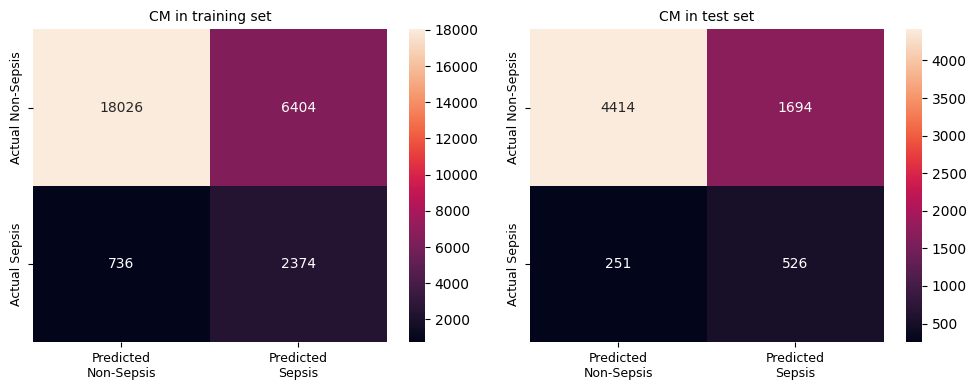


Balanced Accuracy: Training set 0.7506 ; Test set 0.6998
Precision: Training set 0.2704 ; Test set 0.2369
Recall: Training set 0.7633 ; Test set 0.6770
F1 score: Training set 0.3994 ; Test set 0.3510


In [216]:
print("Performance measures on Random Forest Classifier:\n")
performance_measure(t0_rf_best, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

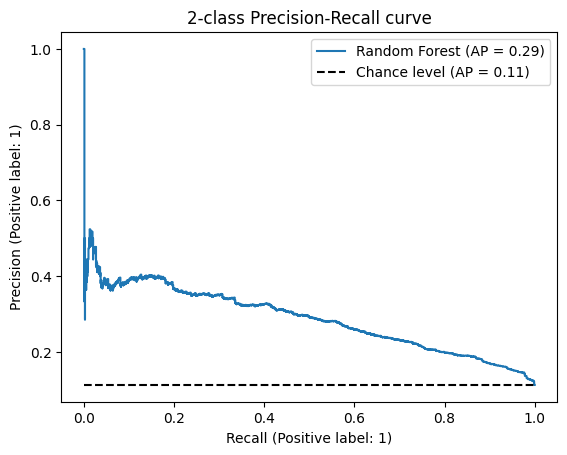

In [217]:
display = PrecisionRecallDisplay.from_estimator(
    t0_rf_best, X_t0_test, y_t0_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.7730


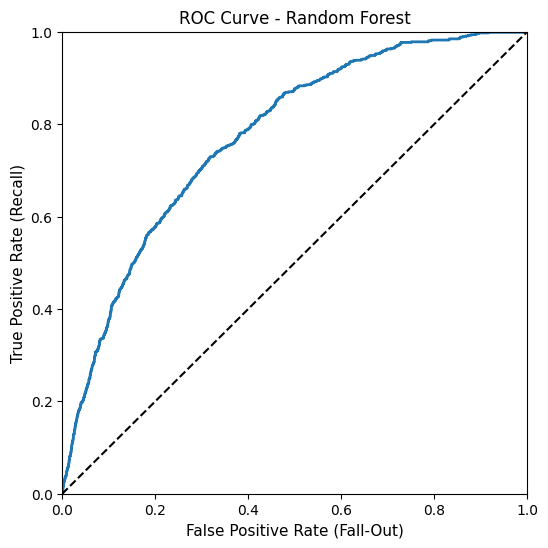

In [218]:
# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_t0_test, t0_rf_predicted_probabilities[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - Random Forest")
plt.grid(False)
plt.show()

#### 5.2.2 t2

In [219]:
t2_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t2_rf_best.fit(X_t2_train, y_t2_train)

# Predict the test set using the best random forest regressor
y_pred_t2_rf = t2_rf_best.predict(X_t2_test)
y_pred_t2_rf = np.round(y_pred_t2_rf) # Round the predictions to the nearest integer
t2_rf_predicted_probabilities = t2_rf_best.predict_proba(X_t2_test)

In [220]:
# Compute the RMSE of the predictions on the test set
rmse_t2_rf = np.sqrt(mean_squared_error(y_t2_test, y_pred_t2_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_t2_rf))

Random Forest Classifier Test set RMSE: 0.4850


Performance measures on Random Forest Classifier:



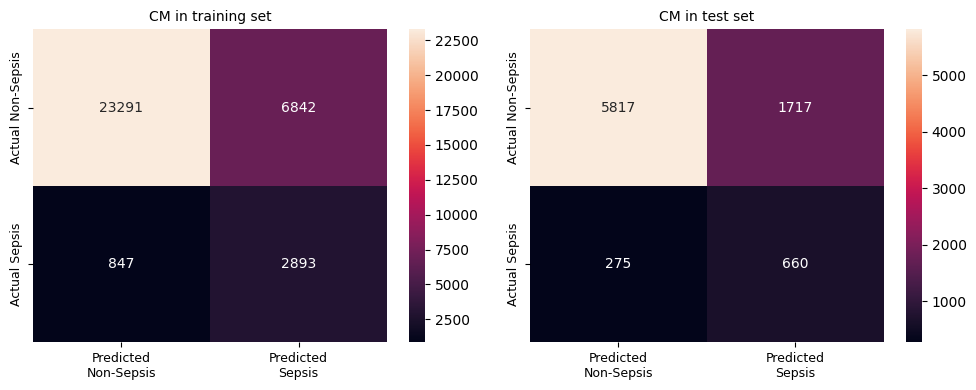


Balanced Accuracy: Training set 0.7732 ; Test set 0.7390
Precision: Training set 0.2972 ; Test set 0.2777
Recall: Training set 0.7735 ; Test set 0.7059
F1 score: Training set 0.4294 ; Test set 0.3986


In [221]:
print("Performance measures on Random Forest Classifier:\n")
performance_measure(t2_rf_best, X_t2_train, X_t2_test, y_t2_train, y_t2_test)

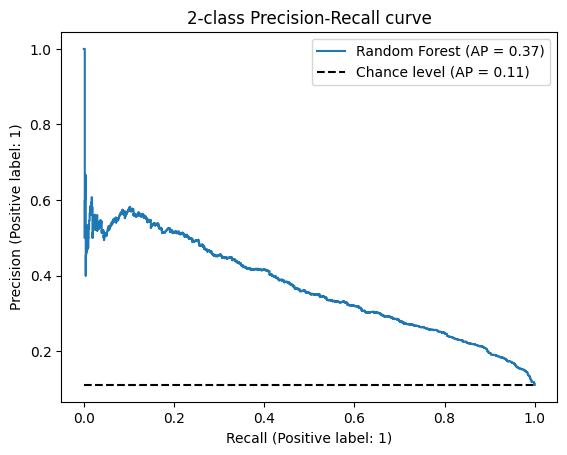

In [222]:
display = PrecisionRecallDisplay.from_estimator(
    t2_rf_best, X_t2_test, y_t2_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.8223


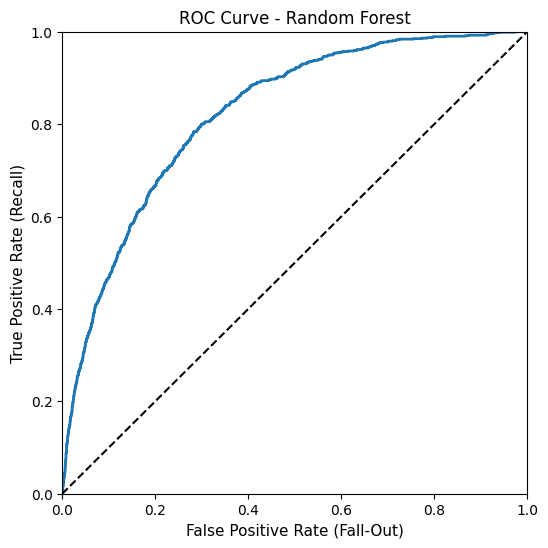

In [223]:
# Plotting ROC curve
fpr_t2_rf_test, tpr_t2_rf_test, thresholds_roc_t2_rf_test = roc_curve(y_t2_test, t2_rf_predicted_probabilities[:, 1], pos_label=1)
auc_t2_rf = auc(fpr_t2_rf_test, tpr_t2_rf_test)
print("AUC = {:.4f}".format(auc_t2_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t2_rf_test, tpr_t2_rf_test)
plt.title("ROC Curve - Random Forest")
plt.grid(False)
plt.show()

#### 5.2.3 t4

In [224]:
t4_rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250)
t4_rf_best.fit(X_t4_train, y_t4_train)

# Predict the test set using the best random forest regressor
y_pred_t4_rf = t4_rf_best.predict(X_t4_test)
y_pred_t4_rf = np.round(y_pred_t4_rf) # Round the predictions to the nearest integer
t4_rf_predicted_probabilities = t4_rf_best.predict_proba(X_t4_test)

In [225]:
# Compute the RMSE of the predictions on the test set
rmse_t4_rf = np.sqrt(mean_squared_error(y_t4_test, y_pred_t4_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_t4_rf))

Random Forest Classifier Test set RMSE: 0.4981


Performance measures on Random Forest Classifier:



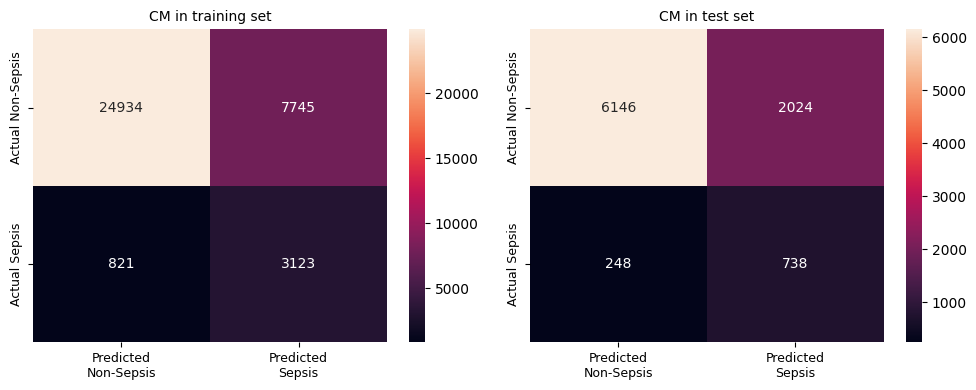


Balanced Accuracy: Training set 0.7774 ; Test set 0.7504
Precision: Training set 0.2874 ; Test set 0.2672
Recall: Training set 0.7918 ; Test set 0.7485
F1 score: Training set 0.4217 ; Test set 0.3938


In [226]:
print("Performance measures on Random Forest Classifier:\n")
performance_measure(t4_rf_best, X_t4_train, X_t4_test, y_t4_train, y_t4_test)

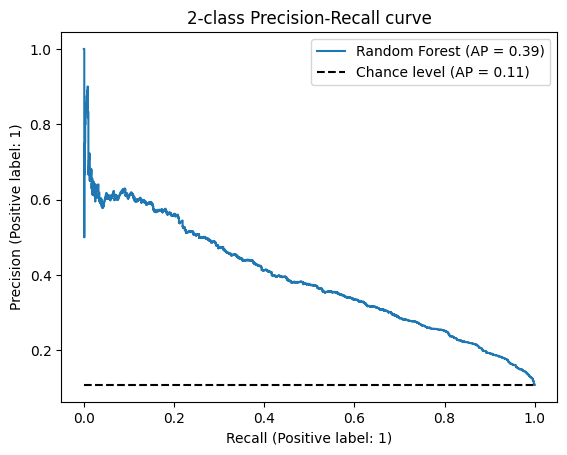

In [227]:
display = PrecisionRecallDisplay.from_estimator(
    t4_rf_best, X_t4_test, y_t4_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.8292


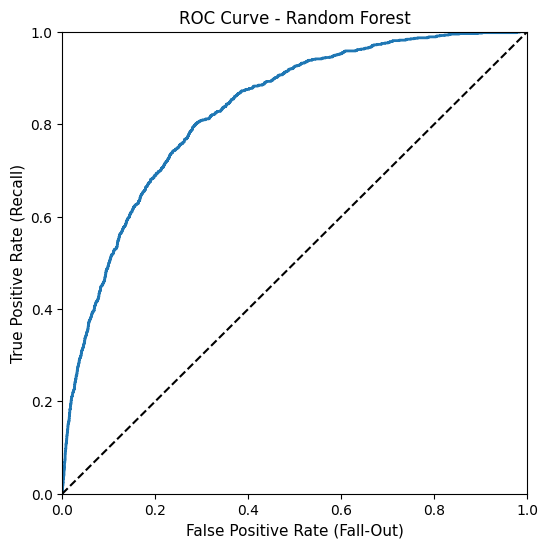

In [228]:
# Plotting ROC curve
fpr_t4_rf_test, tpr_t4_rf_test, thresholds_roc_t4_rf_test = roc_curve(y_t4_test, t4_rf_predicted_probabilities[:, 1], pos_label=1)
auc_t4_rf = auc(fpr_t4_rf_test, tpr_t4_rf_test)
print("AUC = {:.4f}".format(auc_t4_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t4_rf_test, tpr_t4_rf_test)
plt.title("ROC Curve - Random Forest")
plt.grid(False)
plt.show()

### 5.3 Gradient Boosting

#### 5.3.1 t0

In [229]:
# Initialize the Gradient Boosting Classifier
t0_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t0_gb.fit(X_t0_train, y_t0_train, sample_weight=[class_weights[label] for label in y_t0_train])

# Predict on the test set
y_t0_pred = t0_gb.predict(X_t0_test)
t0_gb_predicted_probabilities = t0_gb.predict_proba(X_t0_test)

Performance measures on Gradient Boosting Classifier:



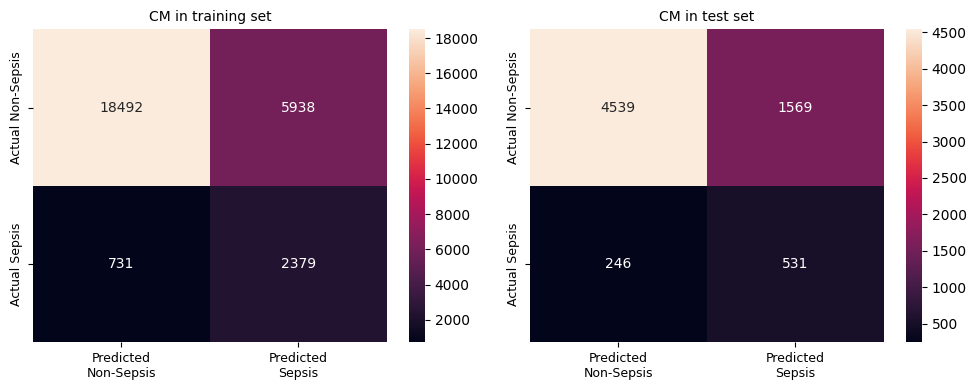


Balanced Accuracy: Training set 0.7609 ; Test set 0.7133
Precision: Training set 0.2860 ; Test set 0.2529
Recall: Training set 0.7650 ; Test set 0.6834
F1 score: Training set 0.4164 ; Test set 0.3691


In [230]:
print("Performance measures on Gradient Boosting Classifier:\n")
performance_measure(t0_gb, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

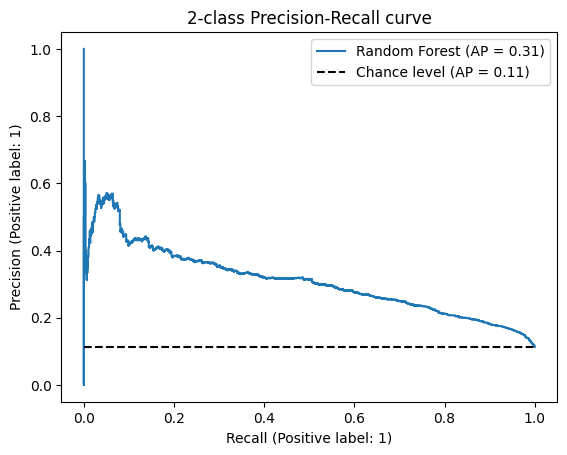

In [231]:
display = PrecisionRecallDisplay.from_estimator(
    t0_gb, X_t0_test, y_t0_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.7892


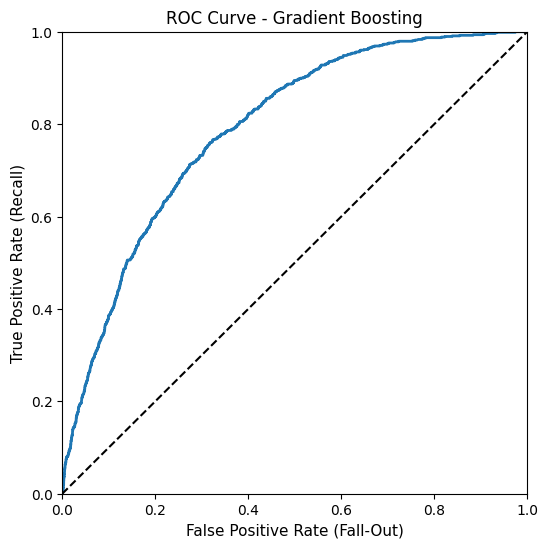

In [232]:
# Plotting ROC curve
fpr_gb_test, tpr_gb_test, thresholds_roc_gb_test = roc_curve(y_t0_test, t0_gb_predicted_probabilities[:, 1], pos_label=1)
auc_t0_gb = auc(fpr_gb_test, tpr_gb_test)
print("AUC = {:.4f}".format(auc_t0_gb))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_gb_test, tpr_gb_test)
plt.title("ROC Curve - Gradient Boosting")
plt.grid(False)
plt.show()

#### 5.3.2 t2

In [233]:
# Initialize the Gradient Boosting Classifier
t2_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t2_gb.fit(X_t2_train, y_t2_train, sample_weight=[class_weights[label] for label in y_t2_train])

# Predict on the test set
y_t2_pred = t2_gb.predict(X_t2_test)
t2_gb_predicted_probabilities = t2_gb.predict_proba(X_t2_test)

Performance measures on Gradient Boosting Classifier:



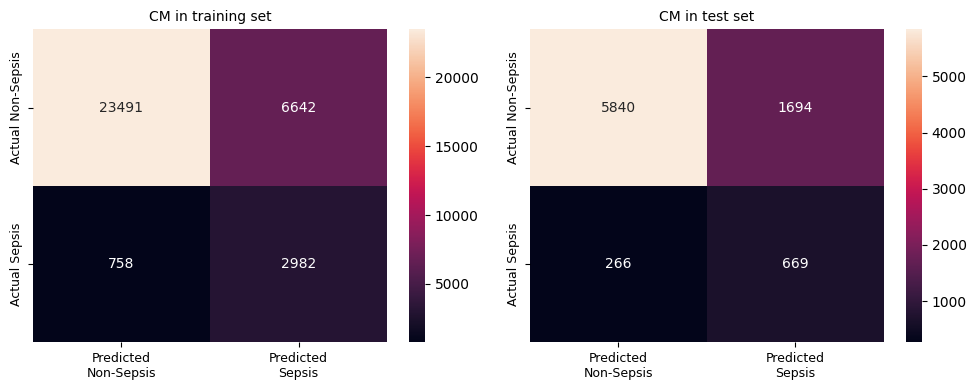


Balanced Accuracy: Training set 0.7885 ; Test set 0.7453
Precision: Training set 0.3099 ; Test set 0.2831
Recall: Training set 0.7973 ; Test set 0.7155
F1 score: Training set 0.4463 ; Test set 0.4057


In [234]:
print("Performance measures on Gradient Boosting Classifier:\n")
performance_measure(t2_gb, X_t2_train, X_t2_test, y_t2_train, y_t2_test)

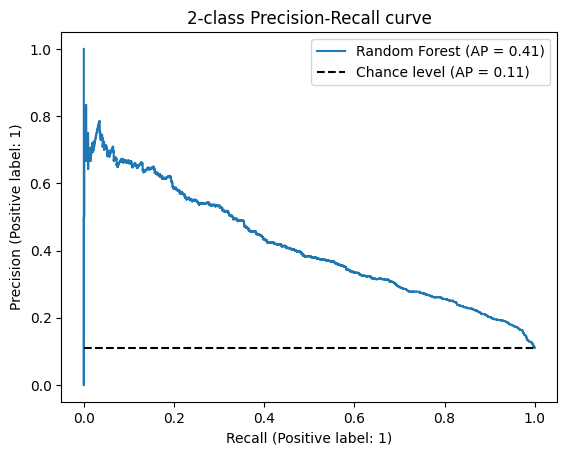

In [235]:
display = PrecisionRecallDisplay.from_estimator(
    t2_gb, X_t2_test, y_t2_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.8337


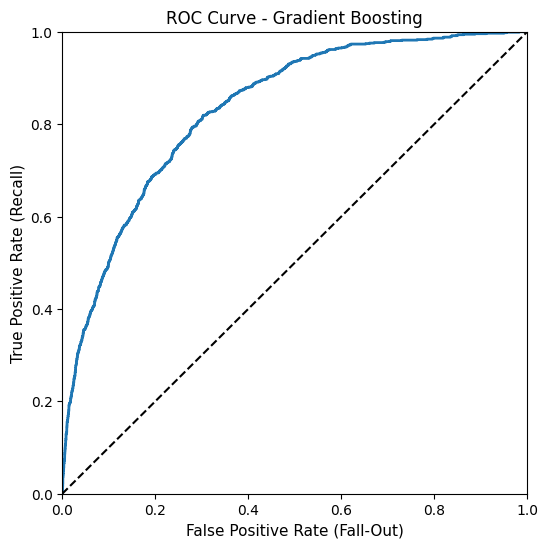

In [236]:
# Plotting ROC curve
fpr_t2_gb_test, tpr_t2_gb_test, thresholds_roc_t2_gb_test = roc_curve(y_t2_test, t2_gb_predicted_probabilities[:, 1], pos_label=1)
auc_t2_gb = auc(fpr_t2_gb_test, tpr_t2_gb_test)
print("AUC = {:.4f}".format(auc_t2_gb))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t2_gb_test, tpr_t2_gb_test)
plt.title("ROC Curve - Gradient Boosting")
plt.grid(False)
plt.show()

#### 5.3.3 t4

In [237]:
# Initialize the Gradient Boosting Classifier
t4_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)

# Train the classifier on the training data
t4_gb.fit(X_t4_train, y_t4_train, sample_weight=[class_weights[label] for label in y_t4_train])

# Predict on the test set
y_t4_pred = t4_gb.predict(X_t4_test)
t4_gb_predicted_probabilities = t4_gb.predict_proba(X_t4_test)

Performance measures on Gradient Boosting Classifier:



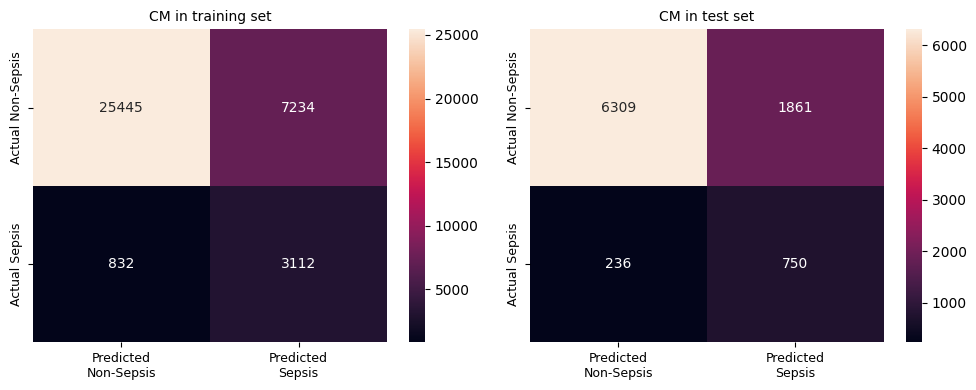


Balanced Accuracy: Training set 0.7838 ; Test set 0.7664
Precision: Training set 0.3008 ; Test set 0.2872
Recall: Training set 0.7890 ; Test set 0.7606
F1 score: Training set 0.4355 ; Test set 0.4170


In [238]:
print("Performance measures on Gradient Boosting Classifier:\n")
performance_measure(t4_gb, X_t4_train, X_t4_test, y_t4_train, y_t4_test)

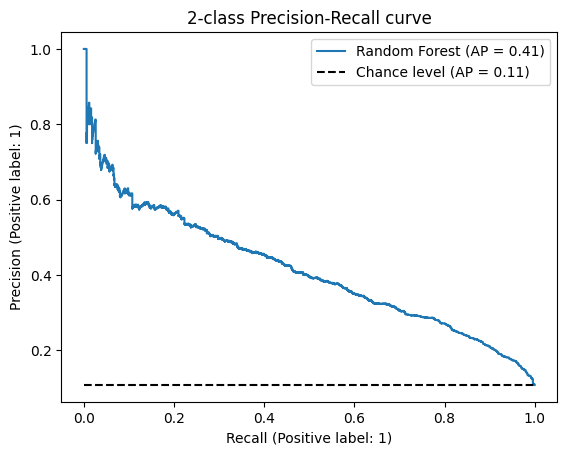

In [239]:
display = PrecisionRecallDisplay.from_estimator(
    t4_gb, X_t4_test, y_t4_test, name="Random Forest", plot_chance_level=True
)
display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("2-class Precision-Recall curve")

AUC = 0.8422


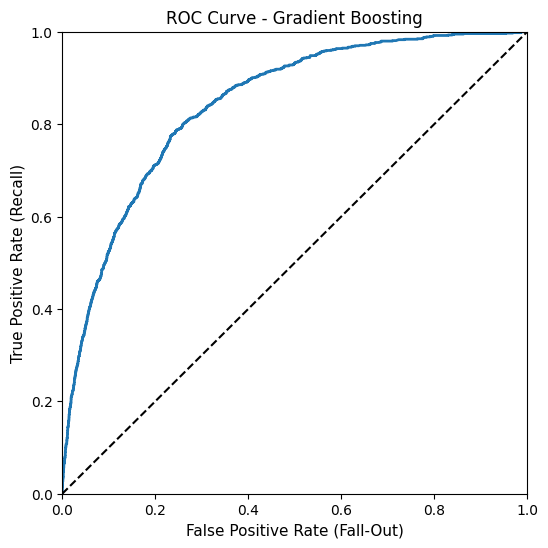

In [240]:
# Plotting ROC curve
fpr_t4_gb_test, tpr_t4_gb_test, thresholds_roc_t4_gb_test = roc_curve(y_t4_test, t4_gb_predicted_probabilities[:, 1], pos_label=1)
auc_t4_gb = auc(fpr_t4_gb_test, tpr_t4_gb_test)
print("AUC = {:.4f}".format(auc_t4_gb))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_t4_gb_test, tpr_t4_gb_test)
plt.title("ROC Curve - Gradient Boosting")
plt.grid(False)
plt.show()

## 6. Model Comparison

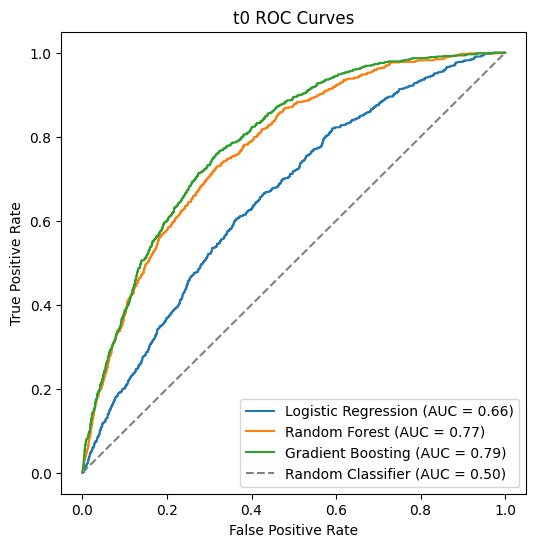

In [246]:
def plot_combined_roc_curves(models, labels, X_test, y_test, title='ROC Curves'):
    """
    This function plots the ROC curve for the provided models.

    :param models: List of trained models
    :param labels: List of labels corresponding to each model
    :param X_test: Test features
    :param y_test: True labels for the test features
    :param title: Title of the plot
    """
    
    if len(models) != len(labels):
        raise ValueError("Number of models must be equal to the number of labels.")
    
    # Initialize the plot
    plt.figure(figsize=(6, 6))
    
    # Iterate over classifiers and plot ROC curve for each
    for model, label in zip(models, labels):
        # Predict the probabilities of the positive class
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.50)')
    
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
    # Show the plot
    plt.show()

plot_combined_roc_curves([t0_lr, t0_rf_best, t0_gb], ['Logistic Regression', 'Random Forest', 'Gradient Boosting'], X_t0_test, y_t0_test, 't0 ROC Curves')

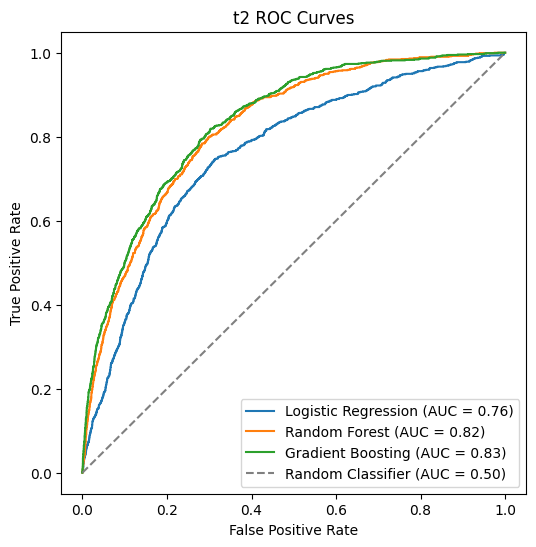

In [247]:
plot_combined_roc_curves([t2_lr, t2_rf_best, t2_gb], ['Logistic Regression', 'Random Forest', 'Gradient Boosting'], X_t2_test, y_t2_test, 't2 ROC Curves')

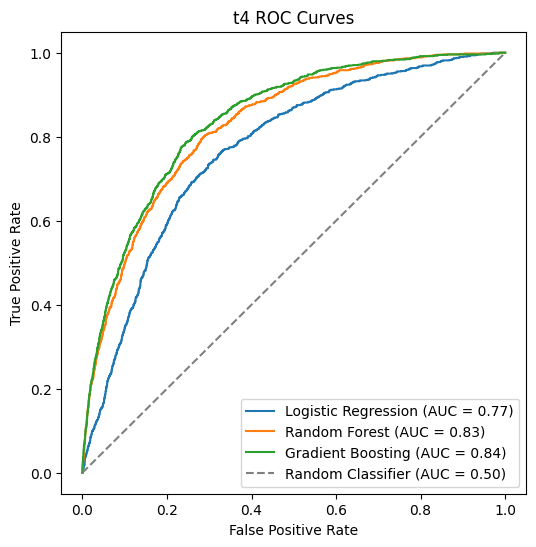

In [248]:
plot_combined_roc_curves([t4_lr, t4_rf_best, t4_gb], ['Logistic Regression', 'Random Forest', 'Gradient Boosting'], X_t4_test, y_t4_test, 't4 ROC Curves')